In [1]:
%matplotlib inline

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import pacf
from joblib import Parallel, delayed
import multiprocessing

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot as plt


## Reading data
shuffling and splitting into Train and Test.

In [3]:
data = pd.read_csv('../data/market_data.csv').drop(columns=['Unnamed: 0', 'Time'])
num_of_ts = data.shape[1]
data_numpy = data.values.T
np.random.shuffle(data_numpy)
train = data_numpy[:num_of_ts/2, :]
test = data_numpy[num_of_ts/2:, :]

## Functions
For Triple Exponentioal Smoothing (Holt Winter), we estimate duration of seasonal perioad using PACF.

In [9]:
def max_diff(arr):
    
    """returns max difference in list, such that
    mininmum appears before maximum"""
    
    max_diff = arr[1] - arr[0]
    min_element = arr[0]
    for val in arr:
        if val - min_element > max_diff:
            min_element_spread = min_element
            max_element_spread = val
            max_diff = val - min_element         
        if val < min_element:
            min_element = val
            
    return max_diff, min_element_spread, max_element_spread


def period_estimation(data, nlags):
    """estimation perioad of the time series"""
    pacf_values = pacf(data, nlags=nlags-1, method='ywunbiased', alpha=None)
    res = np.argmax(np.abs(pacf_values))
    if res < 5:
        res = 5
    return res
   


def train_and_predict_with_holt_winter(ts, train_size=60):
    """Half of time series is used for training, secod half
    for predicition"""
    train, test = ts[:train_size], ts[train_size:]
    period_val = period_estimation(ts, nlags=train_size)
    print period_val
    model = ExponentialSmoothing(train,
                                 seasonal='add',
                                 trend=None,
                                 seasonal_periods=period_val).\
                                 fit()
    return model.predict(start=train_size, end=ts.shape[0]-1)


def estimate_n(data, n, train_size=60):
    """Training and Testing for given parametr n"""
    trade = np.zeros((data.shape[0], 2), dtype=float)
    for i in range(data.shape[0]):
        if i % 500 == 0: 
            print '# of ts processed', i
        predicion = train_and_predict_with_holt_winter(data[i, :])
        pred_std = np.std(predicion)
        _, min_element_spread, max_element_spread = max_diff(data[i, :])
        min_achieved = False
        for val in data[i, 60:]:
            if val < np.min(predicion) + n * pred_std:
                trade[i, 0] = val
                min_achieved = True
            if min_achieved and val > np.max(predicion) - n * pred_std:
                trade[i, 1] = val

                break

    cost_function_n = np.sum(trade[:, 1] - trade[:, 0])
    print 'We have earned {:.3f} with gap parameter = {:.2f}'.format(cost_function_n, n)            
    return {n: cost_function_n}

# Unit tests

In [6]:
%load_ext ipython_unittest

In [7]:
%%unittest_testcase

def test_max_diff(self):
    arr = [9, 1, 2, 4, 10, -10]
    res = (9, 1, 10)
    self.assertTupleEqual(max_diff(arr), res)

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [36]:
`[{0.5: -0.203755733}, {0.7142857142857143: -0.07568558959999999}, {0.9285714285714286: 0.04682280840000001}, {1.1428571428571428: 0.126257921}, {1.3571428571428572: 0.128766536}, {1.5714285714285714: 0.082985329}, {1.7857142857142856: 0.026137132}, {2.0: 0.012689192000000002}]

[{0.5: -0.203755733},
 {0.7142857142857143: -0.07568558959999999},
 {0.9285714285714286: 0.04682280840000001},
 {1.1428571428571428: 0.126257921},
 {1.3571428571428572: 0.128766536},
 {1.5714285714285714: 0.082985329},
 {1.7857142857142856: 0.026137132},
 {2.0: 0.012689192000000002}]

## Training
The Holt Winter training is a bit time consumming.

About ~ 1 hour per data set with single **n** values.

In oreder to make it faster **multiprocessing + joblib** libraries were used to make training faster.

[{1.0: 0.0788820914}, {1.0714285714285714: 0.1071991914}, {1.1428571428571428: 0.123810368}, {1.2142857142857142: 0.13602472399999999}, {1.2857142857142856: 0.135934353}, {1.3571428571428572: 0.131308891}, {1.4285714285714286: 0.128577197}, {1.5: 0.112292241}]

In [10]:
parametrs_range_for_trainig = np.linspace(1, 1.5, 8) 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=num_cores)(delayed(estimate_n)(train, n=val) for val in parametrs_range_for_trainig)
print results

[{1.0: -0.007878353999999997}, {1.0714285714285714: 0.020558426}, {1.1428571428571428: 0.0366285009}, {1.2142857142857142: 0.058747395}, {1.2857142857142856: 0.07626791599999999}, {1.3571428571428572: 0.089185676}, {1.4285714285714286: 0.0979094505}, {1.5: 0.0978555515}]


### Let's plot the cost function (revenue)
The plot, for estimated period via PACF

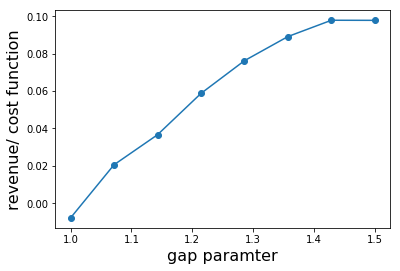

In [11]:
plt.plot([v.keys() for v in results], [v.values() for v in results], marker='o');
plt.xlabel('gap paramter', fontsize=16);
plt.ylabel('revenue/ cost function', fontsize=16);

### Let's plot the cost function (revenue)
The plot, for constant period.

$period= 30$

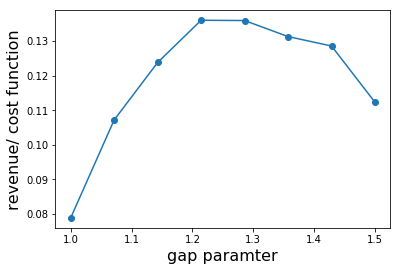

In [47]:
plt.plot([v.keys() for v in results], [v.values() for v in results], marker='o');
plt.xlabel('gap paramter', fontsize=16);
plt.ylabel('revenue/ cost function', fontsize=16);

it seems, that the best results are for $n\approx 1.25$
## Testing

In [50]:
estimate_n(data=test, n=1.25)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
We have earned 0.141 with gap parameter = 1.25


{1.25: 0.141373768}

## Conclustion for Method 1

The results are for test are almost the same as for train.
For full data set it should be:

$$ 0.135 \cdot 2 \approx .27 $$

The above result is a twice worse, than the results with simplest method.
My opinion, that Holt-Winter (HW) results should have better performance.
Since that it worth to invest addtional time to tunning HW method and understanding when and why it fails.

49
28
40
54
45
58
56
40
48
55


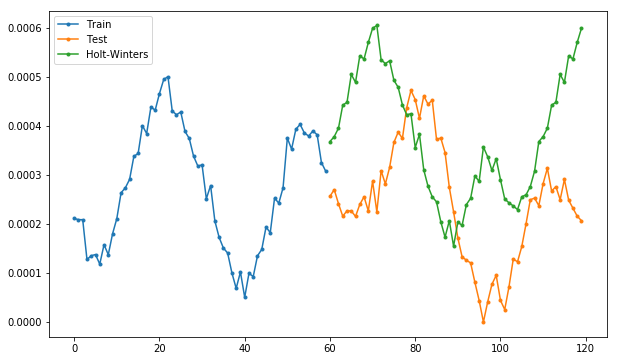

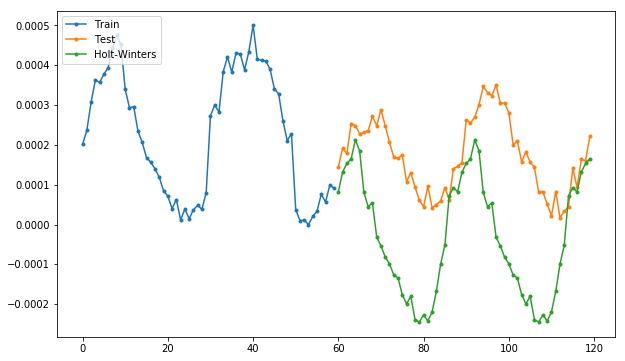

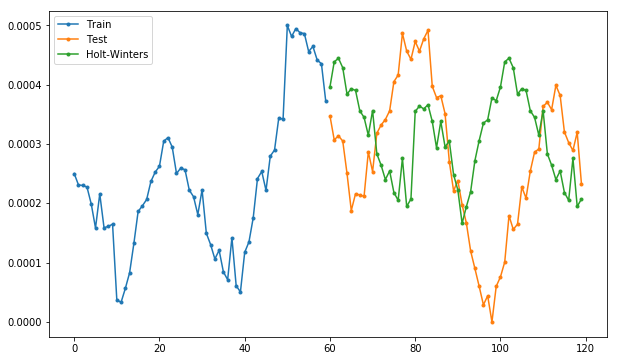

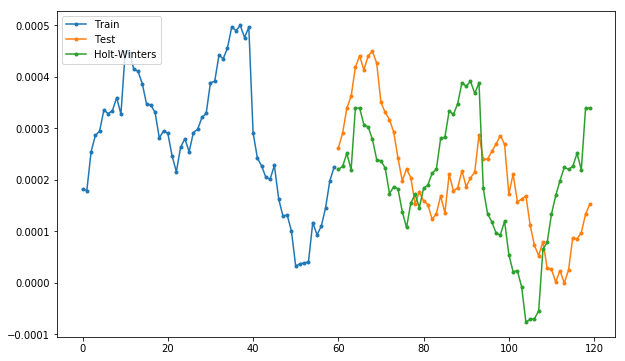

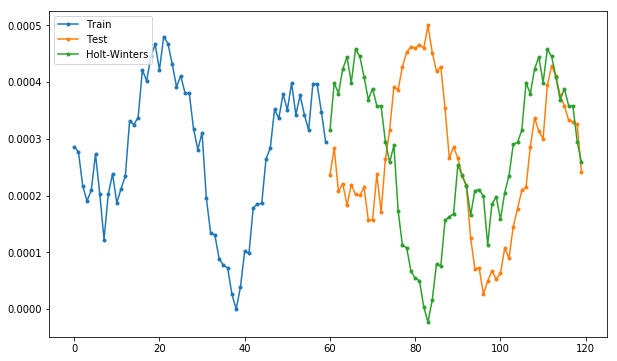

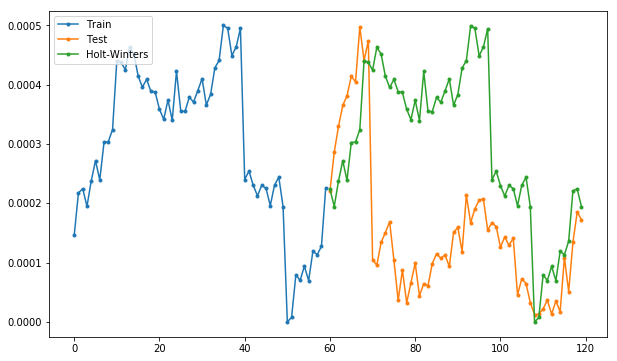

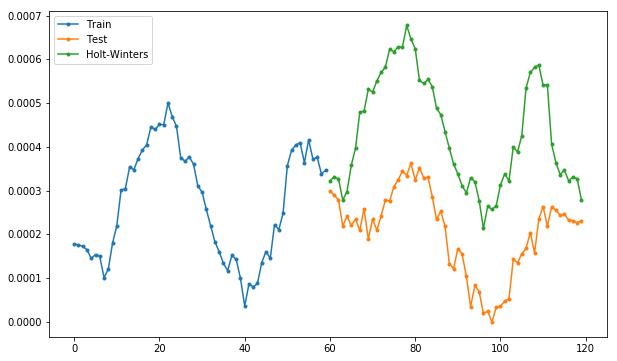

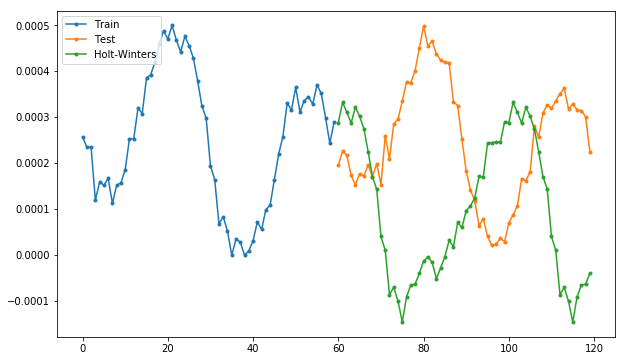

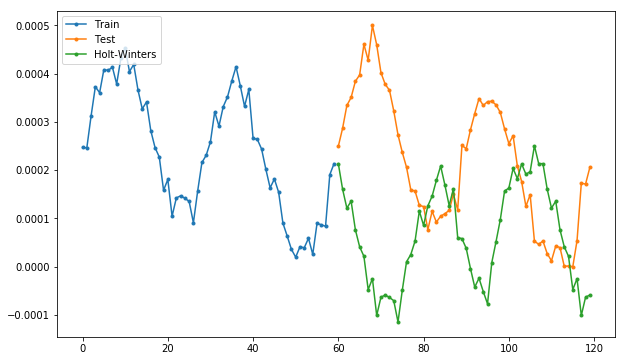

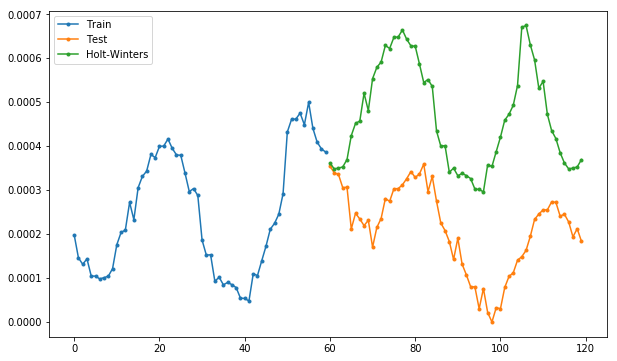

In [23]:
for i in range(10):
    train_size = 60
    train, test = data_numpy[i, :train_size], data_numpy[i, train_size:]

    pred = train_and_predict_with_holt_winter(data_numpy[i,:], train_size=60)
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.plot(range(60), train, marker = '.', label='Train');
    plt.plot(range(60, 120), test, marker='.', label='Test')
    plt.plot(range(60,120), pred, marker='.', label='Holt-Winters')
    plt.legend(loc=2)

<img src="img/max_diff.png",width=400,height=400>

## Some observation of ACF and PACF
no conclusions, but I think the proper use of ACF and PACF is key for ARIMA (SARIMA) -> next TO DO (?)

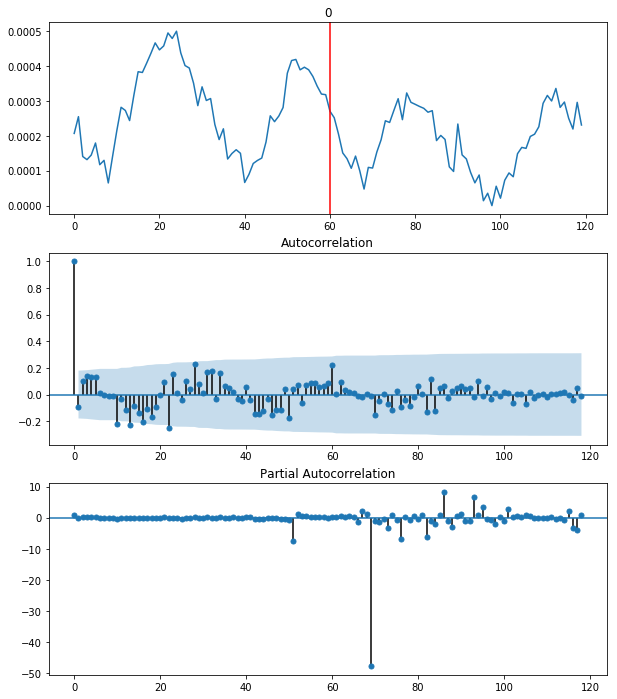

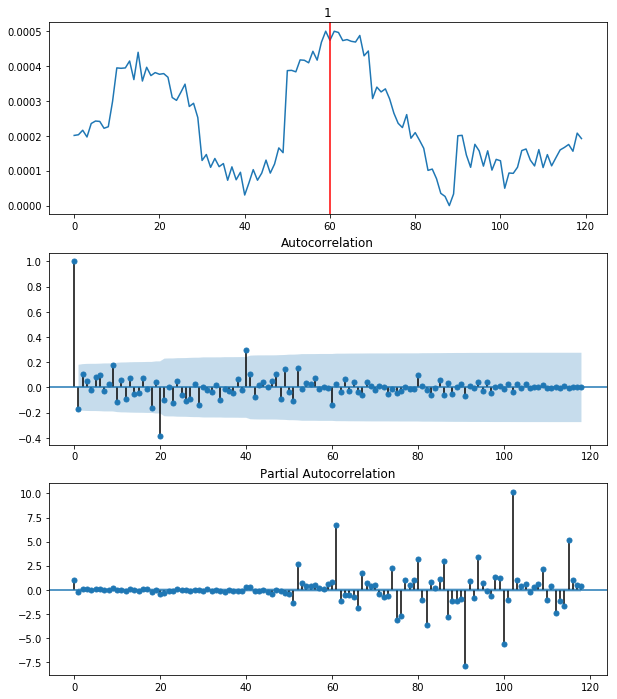

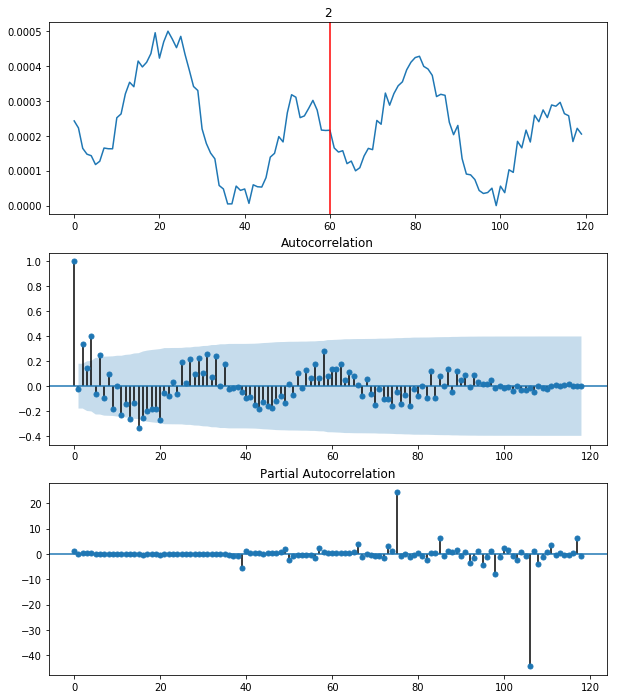

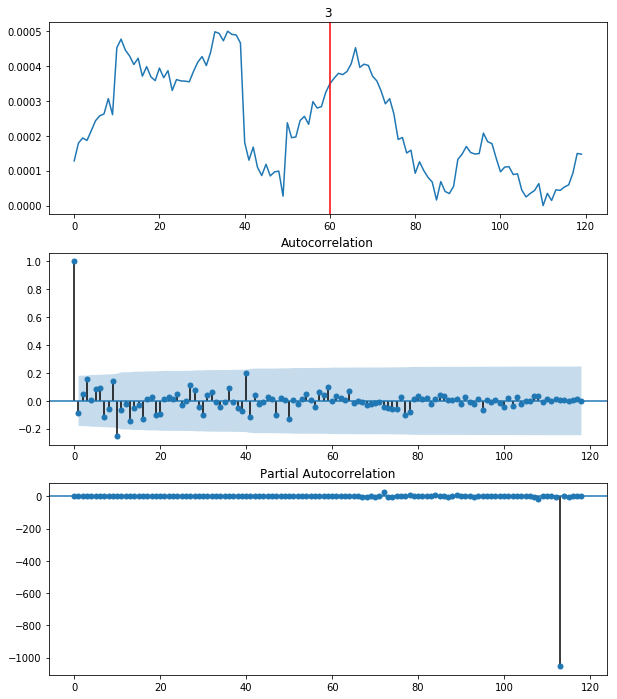

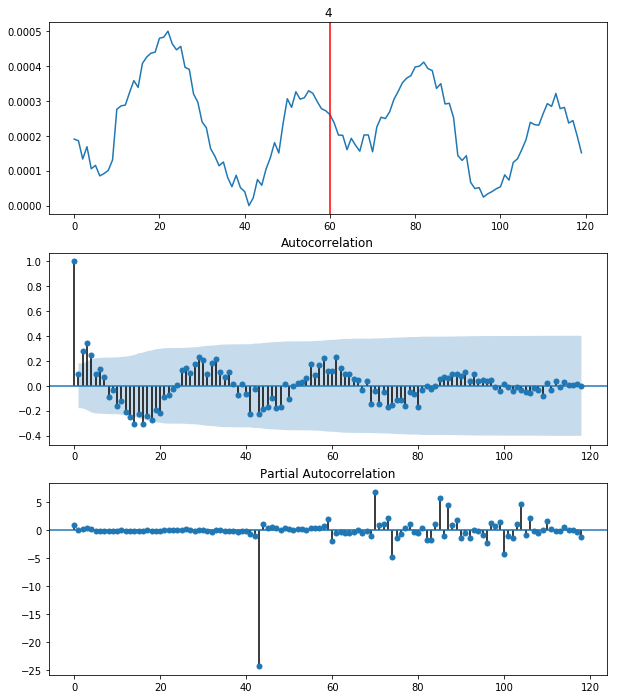

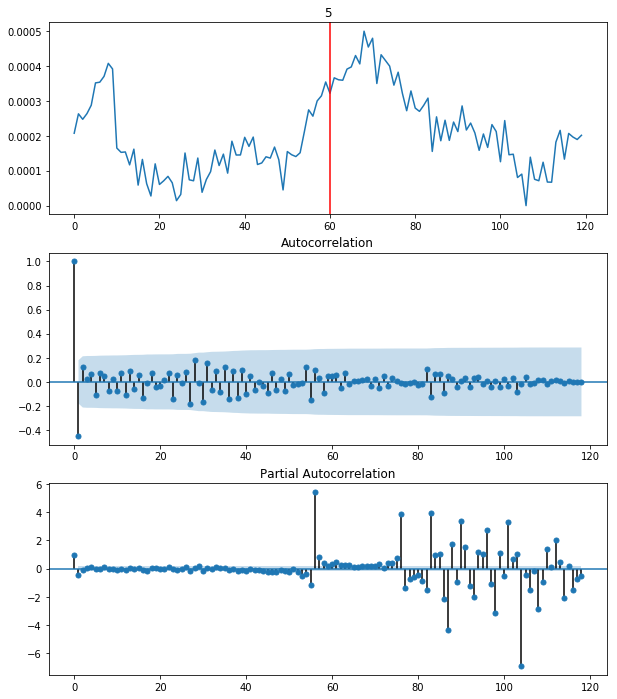

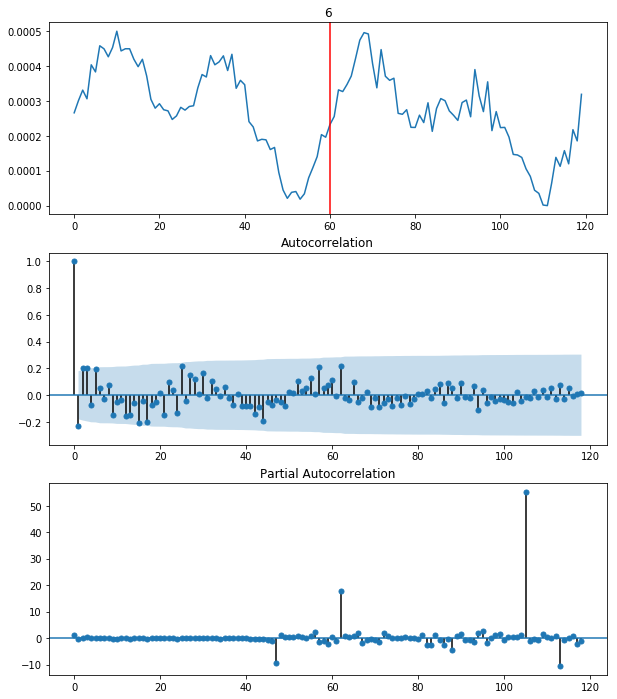

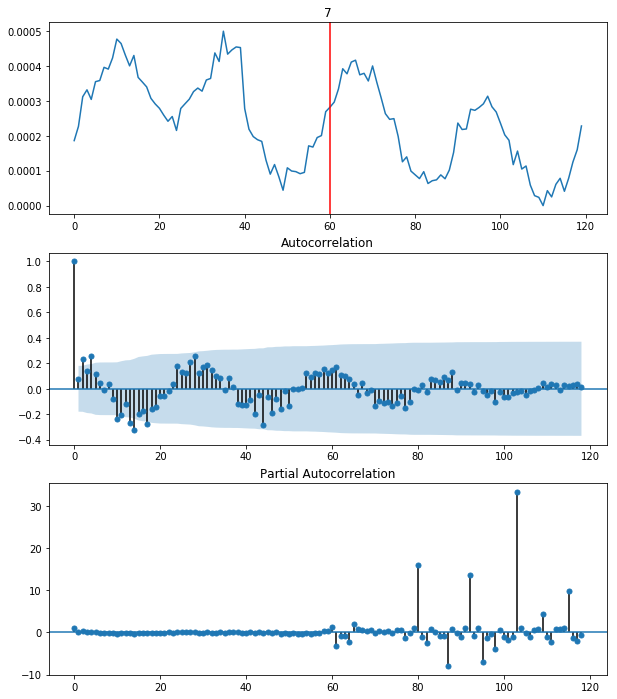

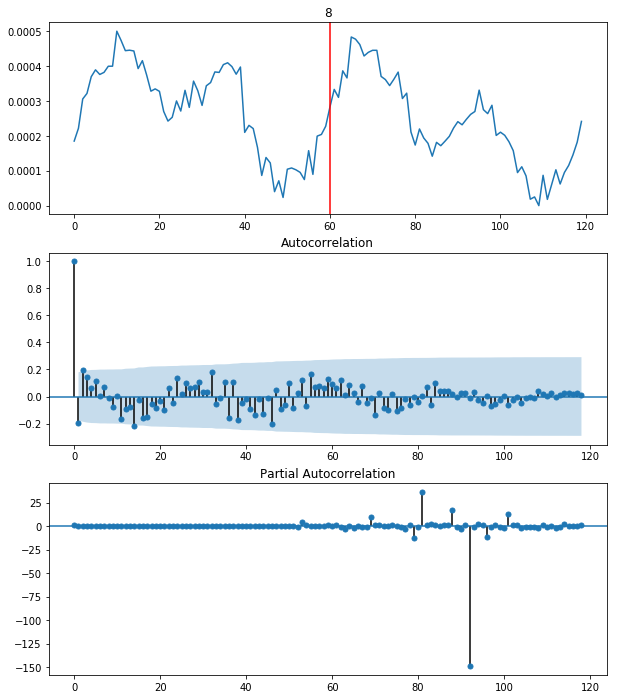

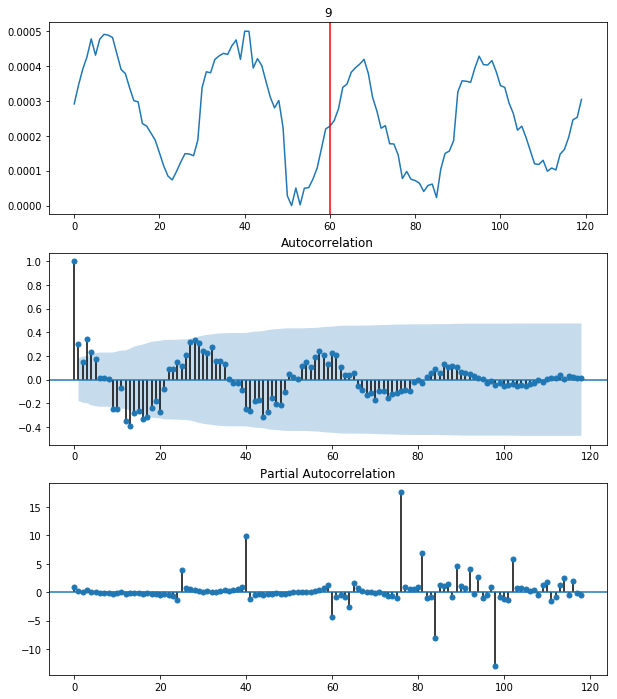

In [49]:
for i in range(10):
    y = data_numpy[i, :]
    plt.figure(figsize=(10, 12))
    plt.subplot(311)
    plt.plot(range(120), (y));
    plt.title(i)
    plt.axvline(60, color='red')
    plt.subplot(312)
    plot_acf(np.diff(y), ax=plt.gca())
    plt.subplot(313)
    plot_pacf(np.diff(y), ax=plt.gca())
    plt.show()

